In [144]:
import pandas as pd

data_frames = {}

#df_ball = pd.read_csv('Data/flipe_latest/name_age_sex_tennis-exp_vr-exp_ball-tracker_2025-06-19_14-28-41..csv')
df_head = pd.read_csv('Data/flipe_latest/name_age_sex_tennis-exp_vr-exp_centereyeanchor_2025-06-19_14-28-40..csv')
df_left_hand = pd.read_csv('Data/flipe_latest/name_age_sex_tennis-exp_vr-exp_lefthandanchor_2025-06-19_14-28-39..csv')

df_racket_bottom = pd.read_csv('Data/flipe_latest/name_age_sex_tennis-exp_vr-exp_racket-frame-base_2025-06-19_14-28-46..csv')
df_racket_left = pd.read_csv('Data/flipe_latest/name_age_sex_tennis-exp_vr-exp_racket-frame-left_2025-06-19_14-28-47..csv')
df_racket_right = pd.read_csv('Data/flipe_latest/name_age_sex_tennis-exp_vr-exp_racket-frame-right_2025-06-19_14-28-48..csv')
df_racket_top = pd.read_csv('Data/flipe_latest/name_age_sex_tennis-exp_vr-exp_racket-frame-top_2025-06-19_14-28-43..csv')

df_string_center = pd.read_csv('Data/flipe_latest/name_age_sex_tennis-exp_vr-exp_racket-stringbed-center_2025-06-19_14-28-44..csv')
df_grip = pd.read_csv('Data/flipe_latest/name_age_sex_tennis-exp_vr-exp_racket-grip-base_2025-06-19_14-28-45..csv')

# df_right_hand = pd.read_csv('Data/flipe_latest/name_age_sex_tennis-exp_vr-exp_righthandanchor_2025-06-19_14-28-42..csv')


#data_frames['left_controller'] = df_left_hand
data_frames['racket_bottom'] = df_racket_bottom
data_frames['racket_left'] = df_racket_left
data_frames['racket_right'] = df_racket_right
data_frames['racket_top'] = df_racket_top
data_frames['string_center'] = df_string_center
data_frames['grip'] = df_grip
#data_frames['right_hand'] = df_right_hand
#data_frames['head'] = df_head


In [145]:
for df in data_frames.values():
    df['hit'] = None

    # Identify collisions ball and racket
    hit_events = df['event'].str.contains('RacketHit', na=False)

    # Mark hits 
    df.loc[hit_events, 'hit'] = True
    df.loc[~hit_events, 'hit'] = False

    # Mark TrialStart
    df['TrialStart'] = None
    spawned_events = df['event'].str.contains('TrialStart', na=False)
    df.loc[spawned_events, 'TrialStart'] = True
    df.loc[~spawned_events, 'TrialStart'] = False

    # Identify court collisions
    df['Court_Enter'] = None
    court_events = df['event'].str.contains('CourtEnter', na=False)
    df.loc[court_events, 'Court_Enter'] = True
    df.loc[~court_events, 'Court_Enter'] = False

    # Identify Net collisions
    df['Net_Enter'] = None
    net_events = df['event'].str.contains('NetEnter', na=False)
    df.loc[net_events, 'Net_Enter'] = True
    df.loc[~net_events, 'Net_Enter'] = False

    # Delete the Event column
    df = df.drop(columns=['event'])

    # Convert Pos and Rot columns to numeric, coercing errors
    df[['time', 'position.x', 'position.y', 'position.z', 'rotation.x', 'rotation.y', 'rotation.z', 'rotation.w']] = df[['time', 'position.x', 'position.y', 'position.z', 'rotation.x', 'rotation.y', 'rotation.z', 'rotation.w']].apply(pd.to_numeric, errors='coerce')

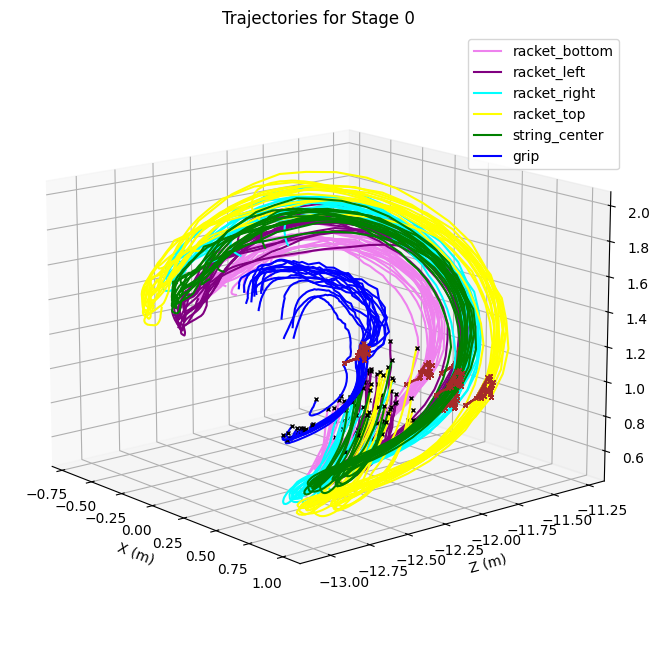

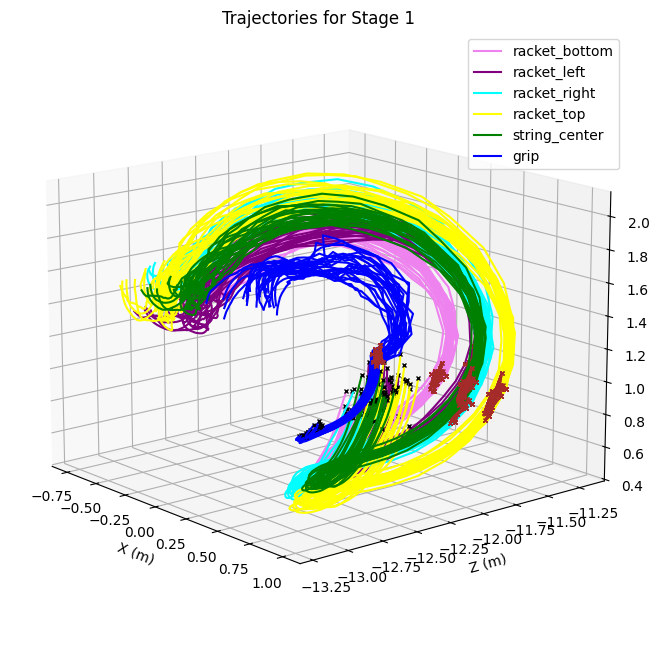

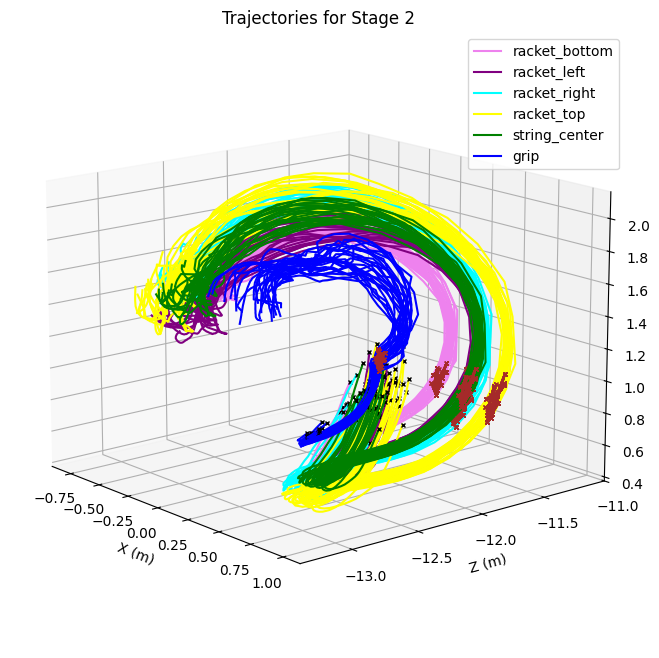

In [146]:
import matplotlib.pyplot as plt

colors = {
    'racket_bottom': 'violet',
    'racket_left': 'purple',
    'racket_right': 'cyan',
    'racket_top': 'yellow',
    'string_center': 'green',
    'grip': 'blue',
    'left_controller': 'orange',
    # 'right_controller': 'purple',
    'head': 'red'
}

WINDOW = 0.5

for i in range(3):  # for each stage
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    for body_part, df in data_frames.items():
        df_stage = df[df["stage"] == i]
        racket_hits = df_stage[df_stage["hit"] == True]
        racket_hits_times = racket_hits.sort_values('time')['time']

        for hit_time in racket_hits_times:
            # Get trajectory around hit time
            window_data = df_stage[(df_stage['time'] >= hit_time - WINDOW) & (df_stage['time'] <= hit_time + WINDOW)]
            if not window_data.empty:
                ax.plot(
                    window_data['position.x'], 
                    window_data['position.z'], 
                    window_data['position.y'],
                    color=colors.get(body_part, 'black'), 
                    label=body_part
                )
                ax.plot(window_data['position.x'].iloc[0], window_data['position.z'].iloc[0], window_data['position.y'].iloc[0], color='black', marker='x', markersize=3)
                ax.plot(racket_hits['position.x'], racket_hits['position.z'], racket_hits['position.y'], color='brown', marker='x', markersize=3)

    ax.set_xlabel('X (m)')
    ax.set_ylabel('Z (m)')
    ax.set_zlabel('Y (m)')
    #ax.set_xlim(-2, 2)
    #ax.set_ylim(-2, 2)
    #ax.set_zlim(-13, 11)
    ax.set_title(f'Trajectories for Stage {i}')
    #ax.view_init(elev=15, azim=-50)
    ax.view_init(elev=15, azim=-40)

    # Avoid duplicate legend entries
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())

    plt.show()
